In [316]:
from itertools import product, combinations
import math
import base64
import io
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import Levenshtein
from sklearn.cluster import SpectralClustering, DBSCAN, AgglomerativeClustering
import numpy as np
import random
import magicsoup as ms
from experiments.e1_co2_fixing.main import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "experiments" / "e1_co2_fixing"

In [4]:
def replicate(t: torch.Tensor, k=25.0) -> torch.Tensor:
    return t ** 3 / (t ** 3 + k ** 3)

def kill(t: torch.Tensor, k=0.005) -> torch.Tensor:
    return k / (t + k)

actions = {"replicated[X]": replicate, "killed[Acetyl-CoA]": kill}
n_mols = [1.0, 2.0, 3.0, 4.0, 5.0]
steps = list(range(1000))

records = []
for action, fun in actions.items():
    for n_mol in n_mols:
        for step in steps:
            records.append({
                "step": step,
                "n(X|Acetyl-CoA)": n_mol,
                "p(action)": (1 - (1 - fun(n_mol)) ** step),
                "action": action,
            })

df = pd.DataFrame.from_records(records)
df["action"] = pd.Categorical(df["action"], categories=[k for k in actions])

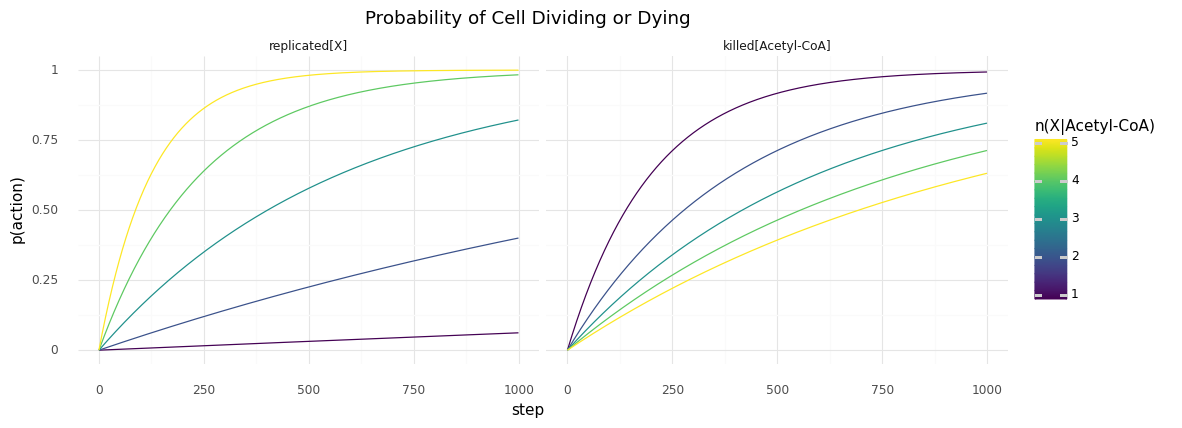

<ggplot: (8793312243703)>

In [5]:
(ggplot(df, aes(y="p(action)", x="step"))
    + geom_line(aes(color="n(X|Acetyl-CoA)", group="n(X|Acetyl-CoA)"))
    + facet_grid(". ~ action")
    + theme(figure_size=(12, 4))
    + ggtitle("Probability of Cell Dividing or Dying"))

In [8]:
runs = {
    "2023-01-13_10-39": "replicate(k=10),kill(k=0.01)",
    "2023-01-13_11-34": "replicate(k=50),kill(k=0.001)",
    "2023-01-13_12-40": "replicate(k=15),kill(k=0.001)"
}

tf_cell_scalars = ["Cells/Divisions[avg]", "Cells/Survival[avg]", "Cells/total[n]"]
records = []
for run_name, hparams in runs.items():
    run_dir = THIS_DIR / "runs" / run_name
    tf_event_file = next(run_dir.glob("*.out.tfevents.*"))
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()    
    for tf_cell_scalar in tf_cell_scalars:
        for obj in tf_ea.Scalars(tf_cell_scalar):
            records.append({
                "hparams": hparams,
                "run": run_name,
                "variable": tf_cell_scalar,
                "value": obj.value,
                "step": obj.step
            })
            if obj.step > 10_000:
                break
df = pd.DataFrame.from_records(records)

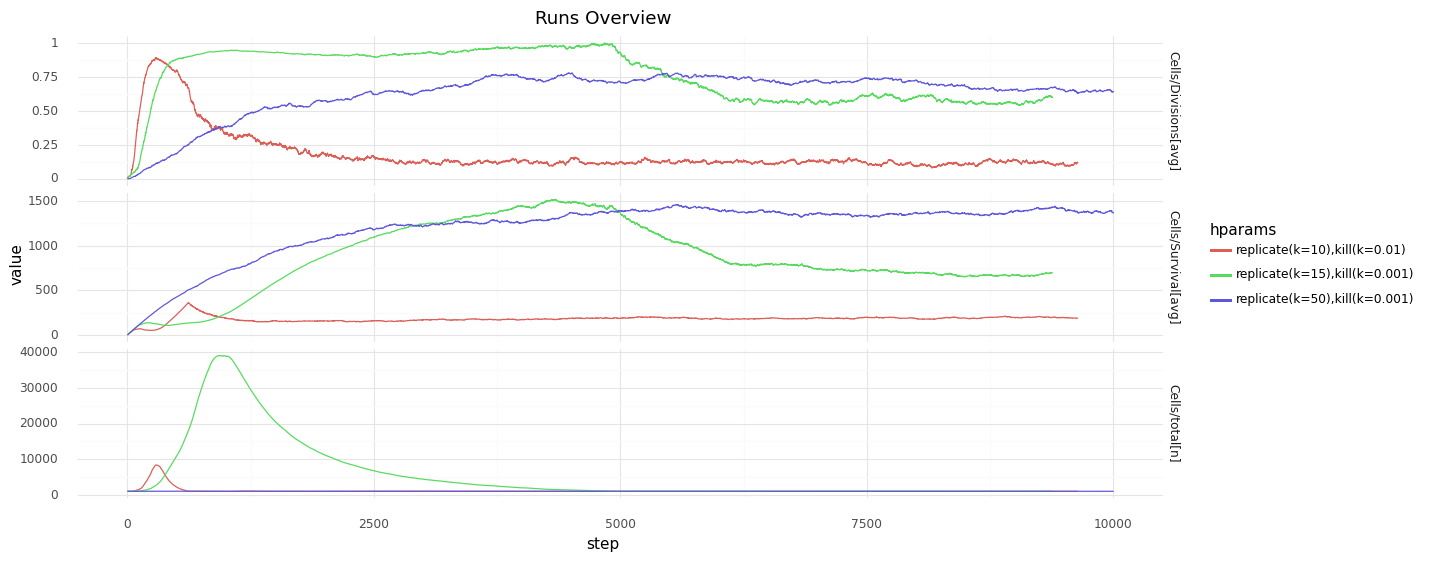

<ggplot: (8774266069387)>

In [9]:
(ggplot(df, aes(y="value", x="step"))
    + geom_line(aes(color="hparams"))
    + facet_grid("variable ~ .", scales="free_y")
    + theme(figure_size=(14, 6))
    + ggtitle("Runs Overview"))

In [11]:
max_idx = df.loc[df["variable"] == "Cells/total[n]", "value"].idxmax()
print(df.loc[max_idx])

run_name = "2023-01-13_12-40"
max_step = 942

hparams     replicate(k=15),kill(k=0.001)
run                      2023-01-13_12-40
variable                   Cells/total[n]
value                             39098.0
step                                  942
Name: 63779, dtype: object


In [2]:
step_range = (0, 2_500)
run_dir = THIS_DIR / "runs" / run_name
tf_event_file = next(run_dir.glob("*.out.tfevents.*"))
tf_ea = event_accumulator.EventAccumulator(str(tf_event_file), {"images": 200})
tf_ea.Reload()

cell_map_imgs = {}
for obj in tf_ea.Images("Maps/Cells"):
    if step_range[0] <= obj.step <= step_range[1]:
        cell_map_imgs[obj.step] = obj.encoded_image_string

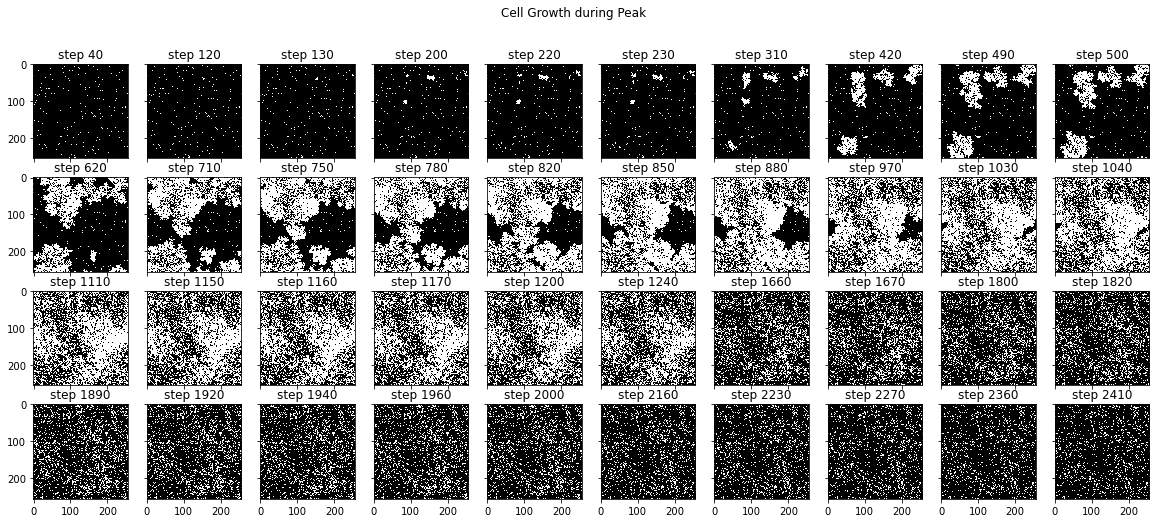

In [ ]:
steps = sorted(list(cell_map_imgs))
n_cols = 10
n_rows = int(len(steps) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 2 * n_rows))
for step, ax in zip(steps, axs.flatten()):
    bimg = io.BytesIO(cell_map_imgs[step])
    img = mpimg.imread(bimg, format='JPG')
    ax.imshow(img, interpolation='nearest')
    ax.title.set_text(f"step {step}")
fig.suptitle("Cell Growth during Peak")
plt.show()

In [12]:
world = ms.World.from_file(rundir=run_dir)
mol_2_idx = {d.name: i for i, d in enumerate(world.genetics.chemistry.molecules)}

all_saved_steps = sorted([int(d.name.split("step=")[1]) for d in run_dir.glob("step=*")])
_, idx = min((abs(d - max_step), i) for (i, d) in enumerate(all_saved_steps))
max_saved_step = all_saved_steps[idx]
world.load_state(statedir=run_dir / f"step={max_saved_step}")

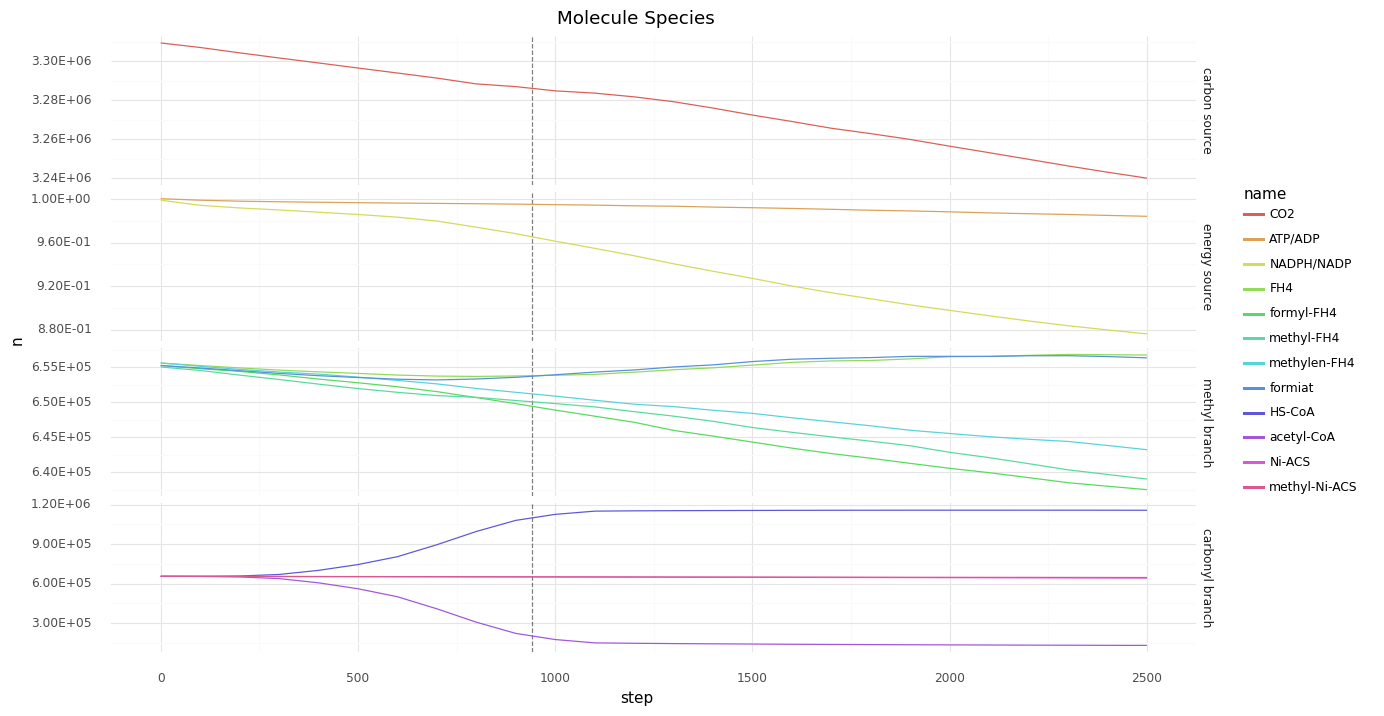

<ggplot: (8774249021784)>

In [16]:
mol_groups = {
    "carbon source": ["CO2"],
    "energy source": ["ATP/ADP", "NADPH/NADP"],
    "methyl branch": ["FH4", "formyl-FH4", "methyl-FH4", "methylen-FH4", "formiat"],
    "carbonyl branch": ["HS-CoA", "acetyl-CoA", "Ni-ACS", "methyl-Ni-ACS"],
}

records = []
for step in [d for d in all_saved_steps if step_range[0] <= d <= step_range[1]]:
    world.load_state(statedir=run_dir / f"step={step}")
    for mol, idx in mol_2_idx.items():
        records.append({
            "molecule": mol,
            "n[i]": world.cell_molecules[:, idx].sum().item(),
            "n[e]": world.molecule_map[idx].sum().item(),
            "n_cells": len(world.cells),
            "step": step
        })
df = pd.DataFrame.from_records(records)

df["n"] = df["n[i]"] + df["n[e]"]
data = df.loc[:, ["molecule", "step", "n"]]
data.rename(columns={"molecule": "name"}, inplace=True)

for high, low in [("ATP", "ADP"), ("NADPH", "NADP")]:
    d = pd.merge(data[data["name"] == high], data[data["name"] == low], on="step")
    d["n"] = d["n_x"] / d["n_y"]
    d["name"] = f"{high}/{low}"
    data = pd.concat([data, d], ignore_index=True)

mol_2_grp = {dd: k for k, d in mol_groups.items() for dd in d}
data["group"] = [mol_2_grp.get(d, "other") for d in data["name"]]
data["group"] = pd.Categorical(data["group"], categories=list(mol_groups) + ["other"])
data["name"] = pd.Categorical(data["name"], categories=list(mol_2_grp))

(ggplot(data[data["name"].isin(list(mol_2_grp))])
    + geom_vline(xintercept=max_step, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="n", x="step", color="name"))
    + scale_y_continuous(labels=lambda d: [f"{dd:.2E}" for dd in d])
    + facet_grid("group ~ .", scales="free_y")
    + theme(figure_size=(14, 8))
    + ggtitle("Molecule Species"))

In [521]:
picker = {
    200: [(40, 153), (35, 90), (105, 85)],
    300: [(225, 50), (40, 220), (25, 240)],
    500: [(200, 100)],
    600: [(210, 160)]
}

records = []
for step in picker:
    world.load_state(statedir=run_dir / f"step={step}")
    for cell_i, cell in enumerate(world.cells):
        records.append({
            "step": soi,
            "x": cell.position[0],
            "y": cell.position[1],
            "cell_idx": cell_i
        })
df = pd.DataFrame.from_records(records)

df["colony"] = "none"
for step, colonies in picker.items():
    step_filter = df["step"] == step
    for coli, (xm, ym) in enumerate(colonies):
        x_filter = (df["x"] >= xm - 5) & (df["x"] <= xm + 5)
        y_filter = (df["y"] >= ym - 5) & (df["y"] <= ym + 5)
        df.loc[step_filter & x_filter & y_filter, "colony"] = f"s{step}:{coli}"

colony_names = sorted(list(set(df["colony"].unique()) - {"none"}))
colors = scale_color_brewer("qual").palette(len(colony_names))
df["colony"] = pd.Categorical(df["colony"], categories=["none"] + colony_names)

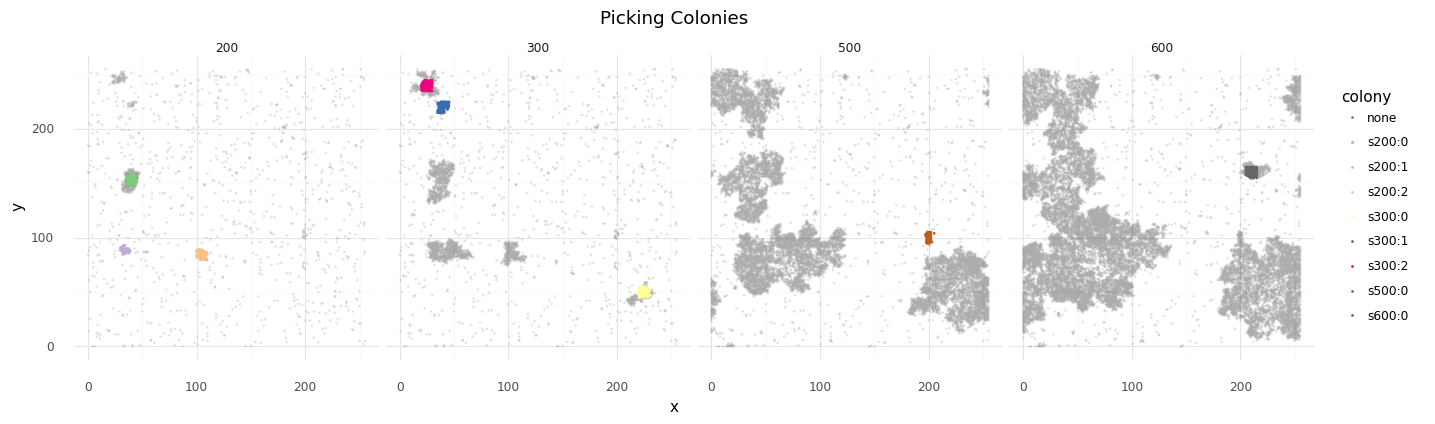

<ggplot: (8774255006651)>

In [522]:
(ggplot(df)
    + geom_point(aes(x="x", y="y", color="colony"), size=0.1)
    + scale_color_manual(values=["#7a7a7a26"] + colors)
    + coord_fixed(ratio=1)
    + facet_wrap("~ step", ncol=4)
    + theme(figure_size=(16, 5))
    + ggtitle("Picking Colonies"))

In [534]:
def distance(seq0: str, seq1: str) -> float:
    if len(seq0) == 0 or len(seq1) == 0:
        return 1.0
    return Levenshtein.distance(seq0, seq1) / max(len(seq0), len(seq1))

world.load_state(statedir=run_dir / f"step={max_saved_step}")
cell_pos_2_idx = {d.position: i for i, d in enumerate(world.cells)}

colony_prototypes = {}
for step in picker:
    step_filter = df["step"] == step
    colnames = set(df.loc[step_filter, "colony"].unique()) - {"none"}
    for colname in colnames:
        pos = df.loc[step_filter & (df["colony"] == colname), ["x", "y"]]
        cell_idxs = [cell_pos_2_idx[d] for d in pos.itertuples(index=False, name=None) if d in cell_pos_2_idx]
        n_col_cells = len(cell_idxs)
        D = np.zeros((n_col_cells, n_col_cells))
        for i, j in combinations(range(n_col_cells), 2):
            ci = world.cells[cell_idxs[i]]
            cj = world.cells[cell_idxs[j]]
            dist = distance(ci.genome, cj.genome)
            D[i, j] = dist
            D[j, i] = dist
        colony_prototypes[colname] = cell_idxs[np.argmin(D.sum(0))]

In [553]:
def norm(x: pd.Series) -> pd.Series:
    mind = np.quantile(x, 0.05)
    maxd = np.quantile(x, 0.95)
    return ((x - mind) / (maxd - mind)).clip(0.0, 1.0)

records = []
for colname, prototype_idx in colony_prototypes.items():
    prototype = world.cells[prototype_idx]
    for cell_idx, cell in enumerate(world.cells):
        records.append({
            "cell_idx": cell_idx,
            "x": cell.position[0],
            "y": cell.position[1],
            "colony": colname,
            "d(prototype)": distance(prototype.genome, cell.genome)
        })
df = pd.DataFrame.from_records(records)

avg_dists = df.groupby("colony")["d(prototype)"].mean().to_dict()
sorted_colonies = sorted([(d, i) for i, d in avg_dists.items()])
df["colony"] = pd.Categorical(df["colony"], categories=[i for _, i in sorted_colonies])

df["dnorm(prototype)"] = 1.0
for colname, cell_idx in colony_prototypes.items():
    col_filter = df["colony"] == colname
    df.loc[col_filter, "dnorm(prototype)"] = norm(df.loc[col_filter, "d(prototype)"])

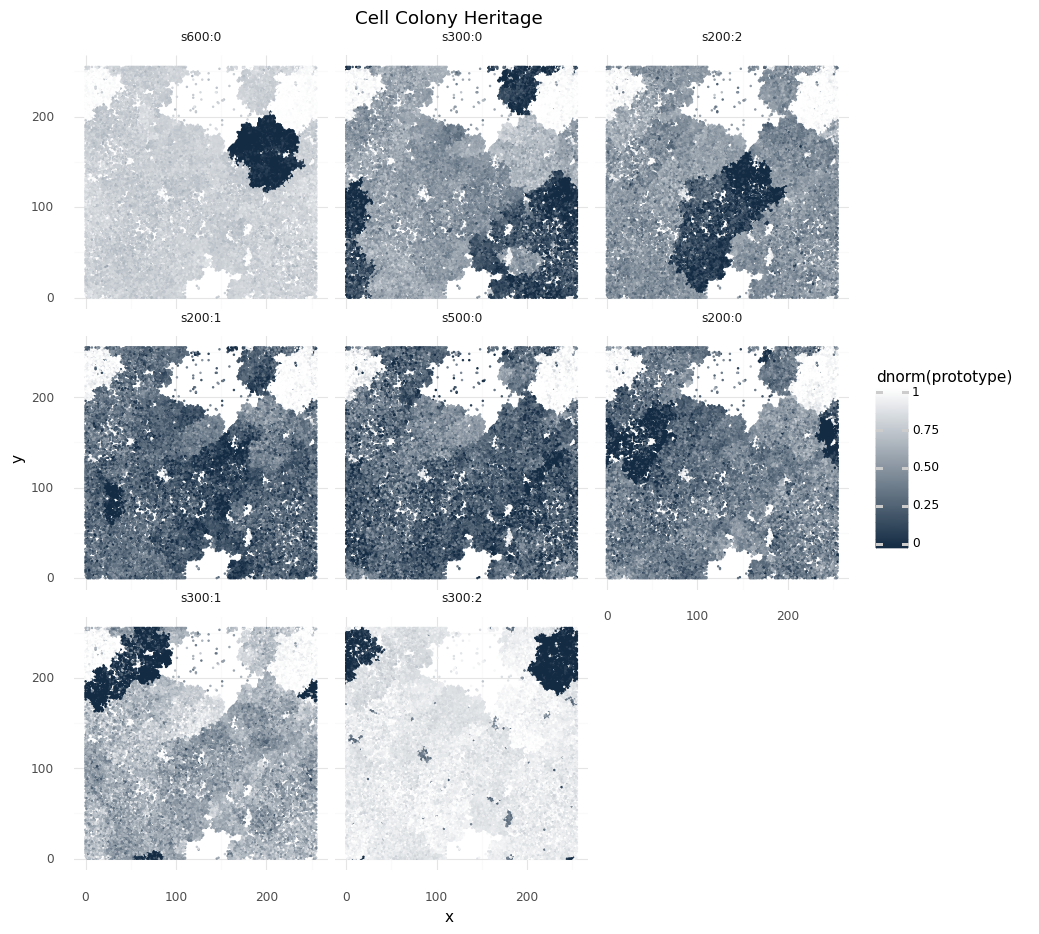

<ggplot: (8774119519202)>

In [554]:
(ggplot(df, aes(x="x", y="y"))
    + geom_point(aes(color="dnorm(prototype)"), size=0.01)
    + scale_color_gradient(low="#132B43", high="#ffffff")
    + coord_fixed(ratio=1)
    + facet_wrap("~ colony", ncol=3)
    + theme(figure_size=(10, 6))
    + ggtitle("Cell Colony Heritage"))

In [583]:
for colname, prototype_idx in colony_prototypes.items():
    prototype = world.cells[prototype_idx]
    print(f"Prototype of Colony {colname}")
    domains = set()
    for protein in prototype.proteome:
        for dom in protein.domains:
            domains.add(dom)
    print(f"   {len(prototype.proteome)} proteins together with domains")
    print("  ", ", ".join(str(d) for d in domains))

Prototype of Colony s200:0
   8 proteins together with domains
   TransporterDomain(X), TransporterDomain(methyl-FH4), CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->acetyl-CoA,Ni-ACS), TransporterDomain(NADP)
Prototype of Colony s200:2
   3 proteins together with domains
   ReceptorDomain(formyl-FH4,cytosolic,inhibiting), TransporterDomain(ATP), CatalyticDomain(NADPH,methylen-FH4->NADP,methyl-FH4)
Prototype of Colony s200:1
   4 proteins together with domains
   CatalyticDomain(acetyl-CoA->X,HS-CoA), ReceptorDomain(FH4,cytosolic,inhibiting)
Prototype of Colony s300:1
   6 proteins together with domains
   TransporterDomain(HS-CoA), CatalyticDomain(methyl-FH4,Ni-ACS->FH4,methyl-Ni-ACS), ReceptorDomain(X,cytosolic,inhibiting), CatalyticDomain(X,HS-CoA->acetyl-CoA)
Prototype of Colony s300:2
   4 proteins together with domains
   CatalyticDomain(NADPH,CO2->NADP,formiat), CatalyticDomain(X,HS-CoA->acetyl-CoA), TransporterDomain(Ni-ACS), TransporterDomain(methyl-FH4)
Prototype of Colony s300:0
